In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from torchvision.transforms import v2
from torchvision.io import read_video
import matplotlib.pyplot as plt
from IPython.display import Video
import math
from torchcodec.decoders import VideoDecoder
from utils import get_model
model, processor = get_model("facebook/vjepa2-vitl-fpc16-256-ssv2")


/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


In [2]:
# example video
video_pth = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/train/P04_41_003015_003031.mp4"
decoder = VideoDecoder(video_pth)
frames = []

for frame in decoder:
    # frame is a torch tensor: [C, H, W], dtype=torch.uint8
    frames.append(frame)

video = torch.stack(frames)  
# convert to channel first 
# video = torch.einsum('thwc->tchw', video) # convert to (t, c, h, w)
print(video.shape)

torch.Size([5, 3, 256, 256])


In [3]:
# example video
video_pth = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/train/P04_33_000471_000487.mp4"
video, audio, video_meta = read_video(video_pth, pts_unit="sec")
# convert to channel first 
video = torch.einsum('thwc->tchw', video) # convert to (t, c, h, w)
print(video.shape)

torch.Size([16, 3, 256, 256])


/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/.venv/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


In [4]:
def create_image_collage(image_list, num_cols=None, figsize=(10, 10)):
    """
    Creates an image collage from a list of image paths using matplotlib.pyplot.

    Args:
        image_paths (list): A list of file paths to the images.
        num_cols (int, optional): The number of columns in the collage grid.
                                   If None, it tries to create a square-like grid.
        figsize (tuple, optional): The size of the figure (width, height) in inches.
                                   Defaults to (10, 10).
    """

    num_images = len(image_list)

    if num_cols is None:
        num_cols = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # Flatten axes for easy iteration, handling cases with a single row/column
    if num_rows == 1 and num_cols == 1:
        axes_flat = [axes]
    elif num_rows == 1 or num_cols == 1:
        axes_flat = axes
    else:
        axes_flat = axes.flatten()

    for i, img in enumerate(image_list):
        if i >= len(axes_flat): # Handle more images than subplots
            break
        axes_flat[i].imshow(img)
        axes_flat[i].axis('off')  # Hide axis labels and ticks
    # Hide any unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

# Normal Image Output

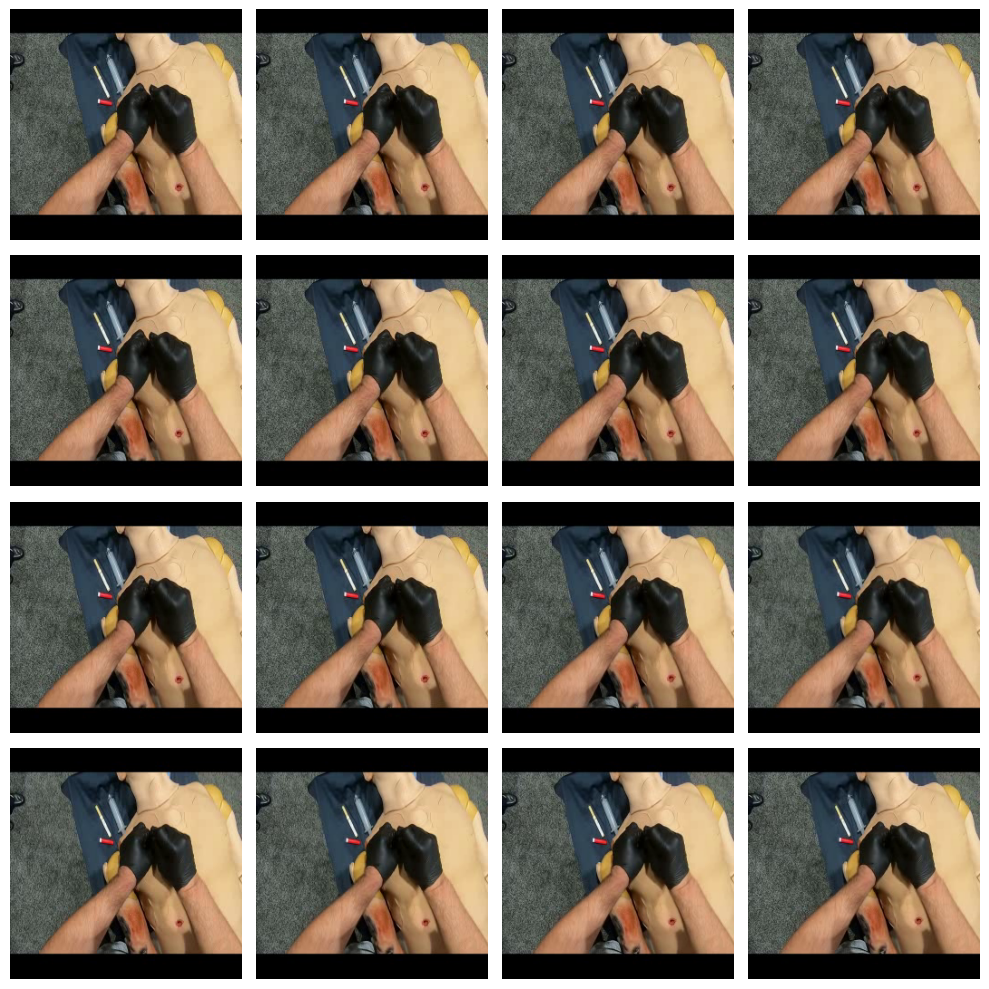

In [5]:
frame = [np.einsum('chw->hwc', frame) for frame in video.numpy()]
create_image_collage(frame, num_cols=4)

# Normalised Image output 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785

Pixel value range BEFORE normalisation: (0, 255)
torch.Size([1, 16, 3, 256, 256])
Range of pixel values AFTER normalisation: (min -2.1179039478302, max 2.517995595932007)


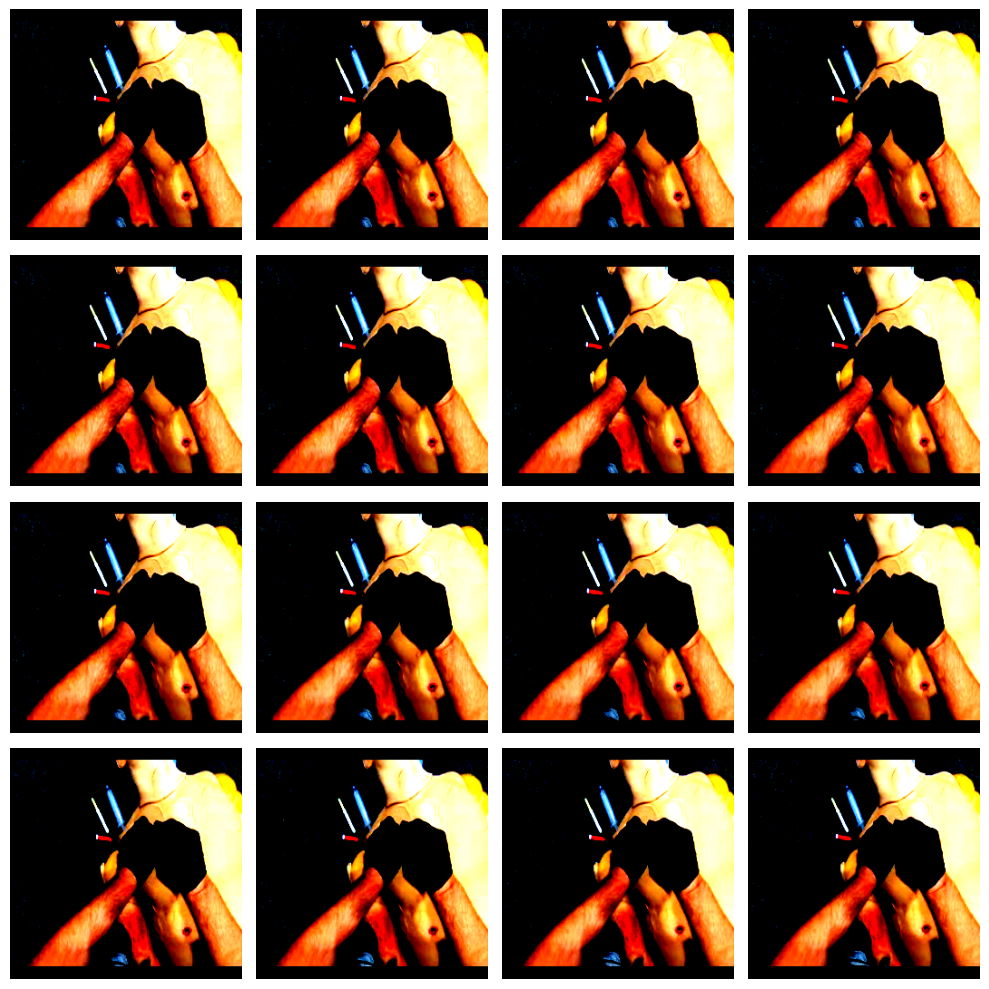

In [6]:
# use the processor from the model to process the video
print(f"Pixel value range BEFORE normalisation: ({video.min()}, {video.max()})")
output = processor(video, return_tensors="pt")
video_norm =output.pixel_values_videos
print(video_norm.shape)
print(f"Range of pixel values AFTER normalisation: (min {video_norm.min()}, max {video_norm.max()})")

normframe = [np.einsum('chw->hwc', frame) for frame in video_norm.squeeze().numpy()]
create_image_collage(normframe, num_cols=4)

# Augmentated Data Output

In [ ]:
video_transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        v2.RandomApply([v2.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )], p=0.5),
        v2.RandomApply([v2.RandomRotation(degrees=10)], p=0.5),
        v2.RandomApply([v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.RandomGrayscale(p=0.2),
        v2.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        v2.RandomApply([v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))], p=0.5),
        v2.RandomAutocontrast(p=0.5),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=0.5),
        v2.RandomInvert(p=0.5),
        v2.RandomPosterize(bits=4, p=0.5),
        v2.RandomSolarize(threshold=128, p=0.5),
    ]
)
augmented_video = video_transform(video)

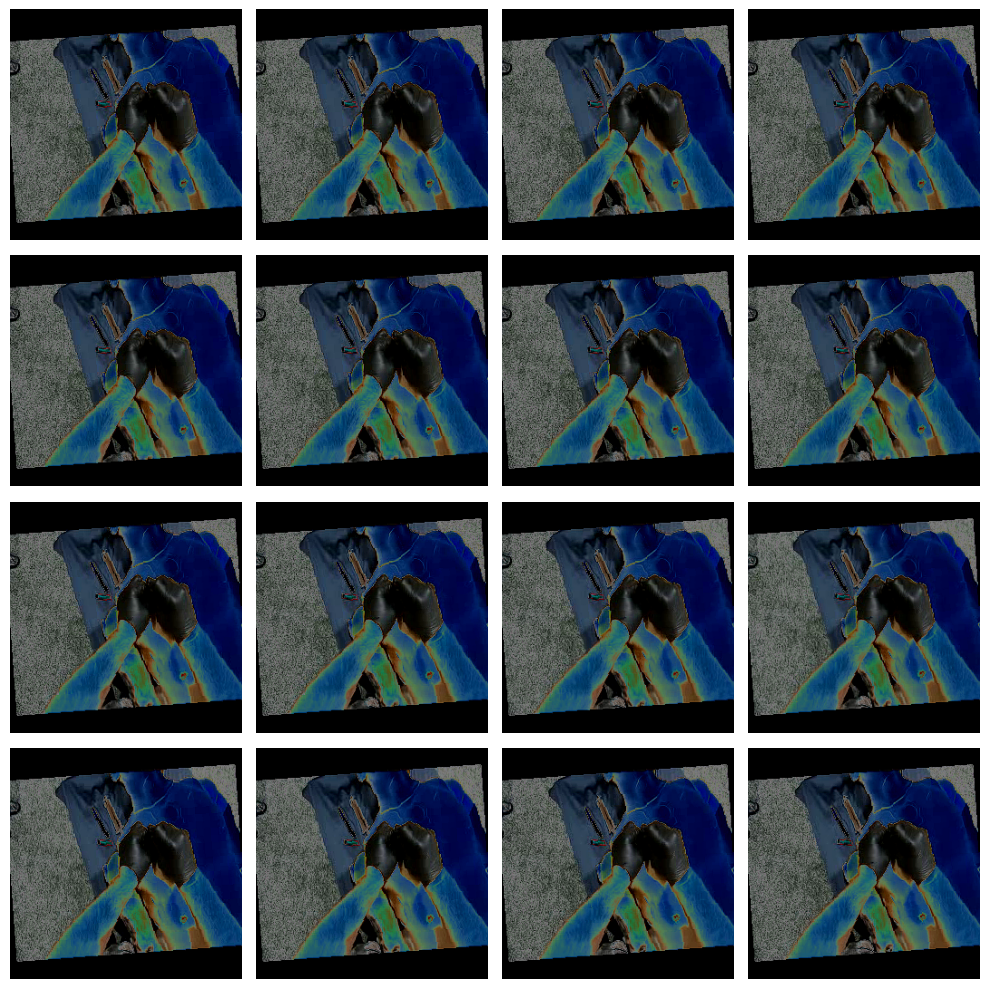

In [8]:
augmented_frame = [np.einsum('chw->hwc', frame) for frame in augmented_video.numpy()]
create_image_collage(augmented_frame, num_cols=4)

---

# Build Dataloader

In [9]:
class VideoDataset(Dataset):
    def __init__(
        self,
        csv_pth,
        video_dir,
        frame_length=16,
        frame_size=(256, 256),
        transform=None,
        mode="train",
    ):
        self.csv_pth = csv_pth
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        # get train/val inputs
        self.df = pd.read_csv(csv_pth).query(f"split == '{mode}'")
        self.split_video_dir = os.path.join(video_dir, mode)
        self.video_size = (
            frame_length,
            3,
            frame_size[0],
            frame_size[1],
        )  # (t, c, h, w)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_pth = os.path.join(
            self.split_video_dir, self.df.iloc[idx]["clip_id"] + ".mp4"
        )
        video, audio, video_meta = read_video(video_pth, pts_unit="sec")
        video = torch.einsum("thwc->tchw", video)  # convert to (t, c, h, w)
        # video has different time length during extraction process
        try:
            assert video.shape == self.video_size, "Video shape mismatch"
        except AssertionError:
            pad_t = self.video_size[0] - video.shape[0]
            if pad_t <= 5:
                # if the video is too short, we will pad it with the last (t - t_n) frames
                print(
                    f"{video_pth} has shape {video.shape} but expected {self.video_size}"
                )
                print("Proceed with padding ...")
                # pad the video the final (t - t_n) frames
                pad = video[video.shape[0] - pad_t : video.shape[0]]
                video = torch.cat((video, pad), dim=0)
            else:
                print(
                    f"Video is too short, skipping ..."
                    f"{video_pth} has shape {video.shape} but expected {self.video_size}"
                )
                print("Resampling with new index ...")
                new_idx = np.random.randint(0, len(self.df))
                return self.__getitem__(new_idx)
        if (self.transform is not None) and (self.mode == "train"):
            video = self.transform(video)
        return video, self.df.iloc[idx]["action_idx"]

# Sanity Check on Dataloader Outputs

In [10]:
csv_pth = "./outputs/data_prep_split.csv"
video_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/"

video_dataset = VideoDataset(csv_pth, video_dir, transform=video_transform, mode="train")
video_loader = DataLoader(video_dataset, batch_size=16, shuffle=True)

for batch, label in video_loader:
    print(batch.shape)
    print(label)
    break


/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/.venv/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


torch.Size([16, 16, 3, 256, 256])
tensor([108, 118, 108, 118, 123,   2,  98,  63,  67,  71,  91, 110, 109,  67,
        111,  31])


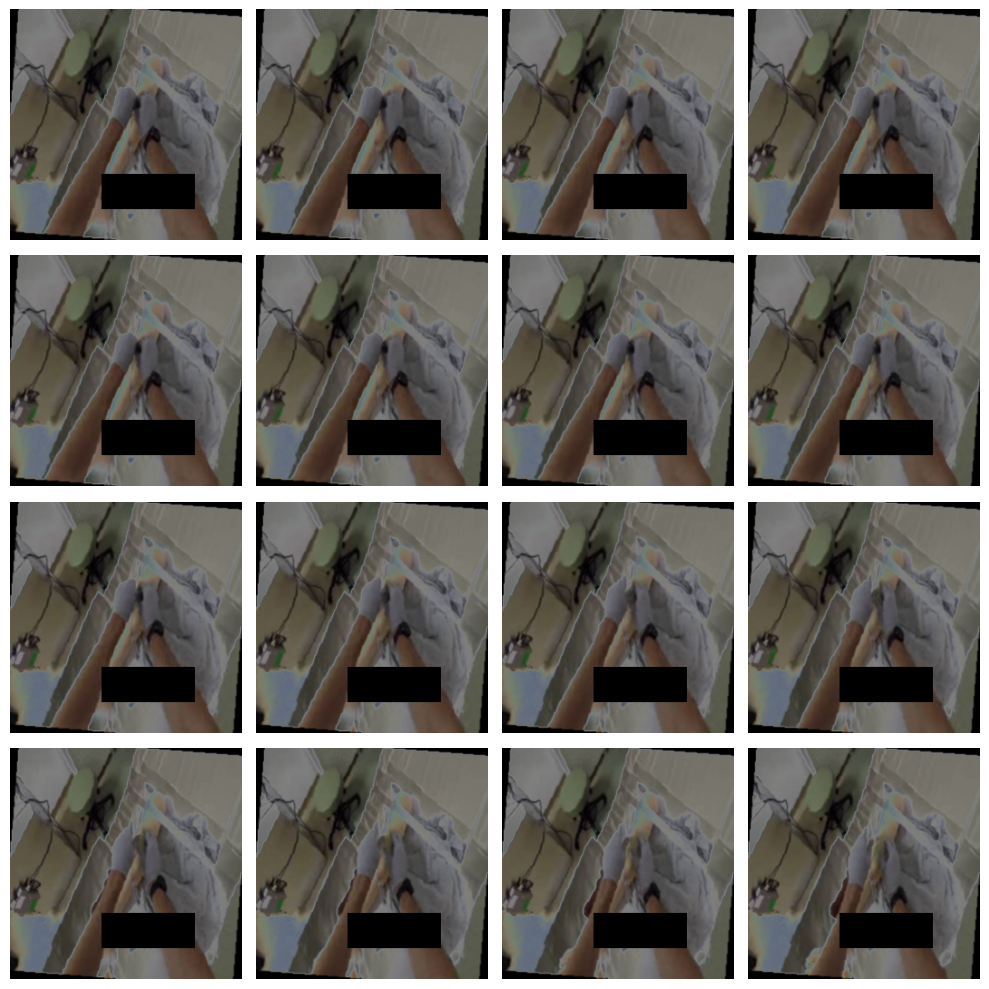

In [11]:
# Output of Batch after data augmentation
example_image = batch[0]
processed_frame = [np.einsum('chw->hwc', frame) for frame in example_image.numpy()]
create_image_collage(processed_frame, num_cols=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.4090632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.40

Pixel value range BEFORE processing: (min 0, max 255)
torch.Size([1, 1, 16, 16, 3, 256, 256])
torch.Size([16, 16, 3, 256, 256])
Pixel value range after processing: (min -2.1179039478302, max 2.640000104904175)


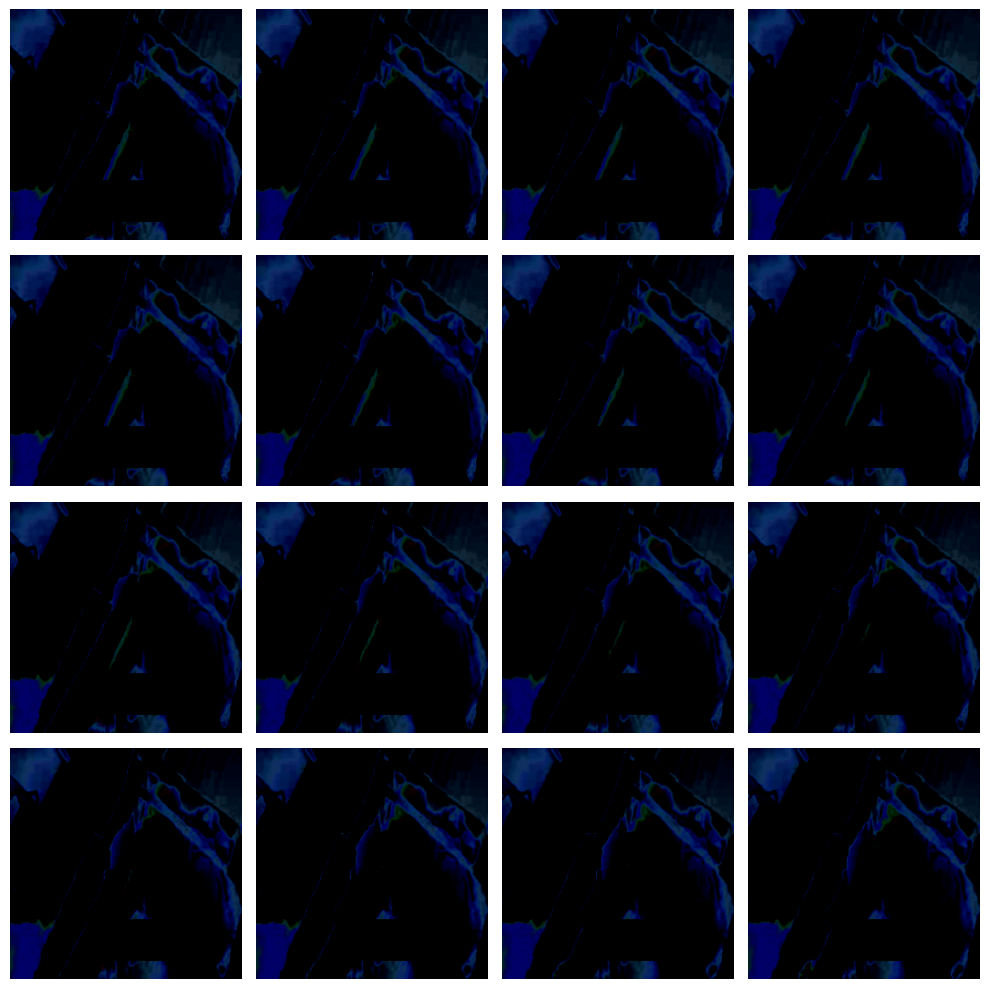

In [12]:
print(f"Pixel value range BEFORE processing: (min {batch.min()}, max {batch.max()})")
inputs = processor(batch, return_tensors="pt")
print(inputs.pixel_values_videos.shape)
batch_output = inputs.pixel_values_videos.squeeze()
print(batch_output.shape)
print(f"Pixel value range after processing: (min {batch_output.min()}, max {batch_output.max()})")
batch_01 = batch_output[0]
batch_frame = [np.einsum('chw->hwc', frame) for frame in batch_01.numpy()]
create_image_collage(batch_frame, num_cols=4)